## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [1]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
#import sys
#!{sys.executable} -m pip install -I networkx==2.1
#import pkg_resources
#pkg_resources.require("networkx==2.1")
import networkx as nx

In [2]:
nx.__version__

'2.1'

In [3]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from grid3 import create_grid_and_edges
import numpy.linalg as LA
%matplotlib inline 

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders2.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [6]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [7]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [8]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

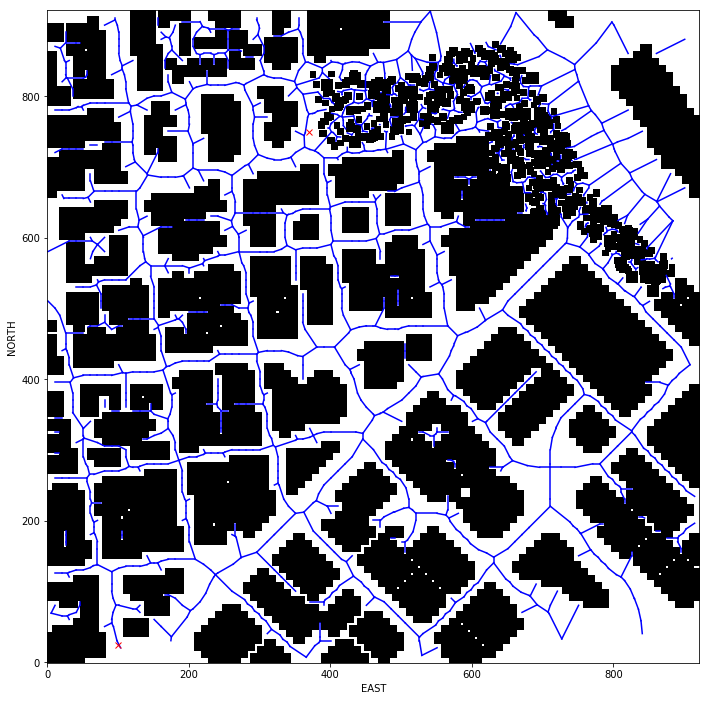

In [9]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G.add_edge(p1, p2, weight=dist)
```

In [10]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()
for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1), ord=2)
    G.add_edge(p1, p2, weight=dist)


You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [22]:
from queue import PriorityQueue

def heuristic(n1, n2):
    return LA.norm(np.array(n2) - np.array(n1), ord=2)

###### THIS IS YOUR OLD GRID-BASED A* IMPLEMENTATION #######
###### With a few minor modifications it can work with graphs! ####
#TODO: modify A* to work with a graph
def a_star(graph, heuristic, start, goal):
    
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
            
        else:
            for next_node in G[current_node]:
                # get the tuple representation
                cost = G.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)  
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))      
                    branch[next_node] = (new_cost, current_node)
    path = []
    path_cost = np.inf
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

### Solution

Find the closest point in the graph to our current location, same thing for the goal location.

In [23]:
def closest_node(graph, point):
    h = []
    for node in graph.nodes:
        dist = LA.norm(np.array(point) - np.array(node), ord=2)
        heapq.heappush(h, (dist, node))
    return heapq.heappop(h)[1]

start_node = closest_node(G, start_ne)
goal_node = closest_node(G, goal_ne)

Compute the path from the two points in the graph using the A* algorithm.

In [24]:
# Run A* on the graph
path, cost = a_star(G, heuristic, start_node, goal_node)
print('Cost: {}'.format(cost))

Found a path.
Cost: 39018.40426679245


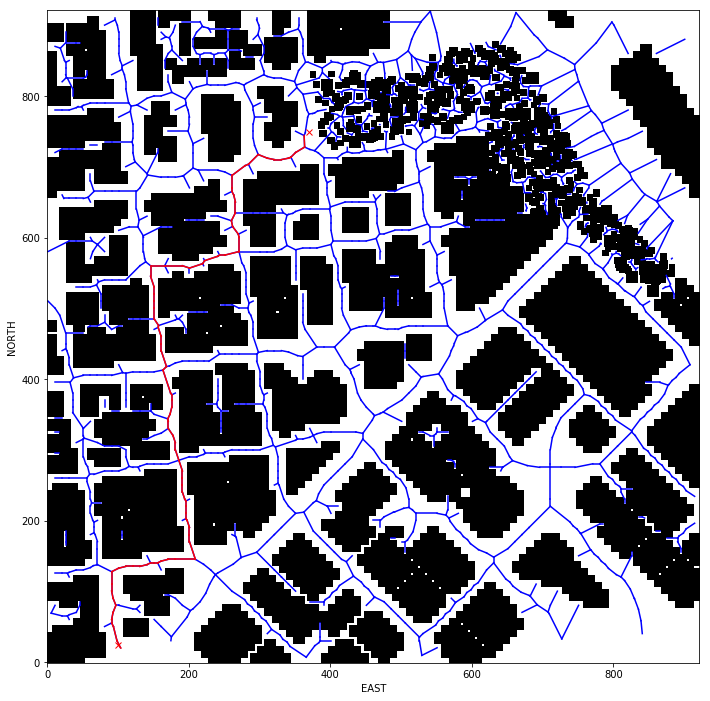

In [27]:
# plot the map
plt.imshow(grid, origin='lower', cmap='Greys') 

# plot the graph
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

# plot start and goal
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

# plot the path
for i in range(len(path) - 1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

[our solution](/notebooks/Graph-Search-Solution.ipynb)